add description

In [183]:
import warnings
warnings.filterwarnings('ignore')

import os
from dotenv import load_dotenv
load_dotenv()

import re
from typing import Dict
import pprint
from langchain import hub
from langchain.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain.prompts import PromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain_community.tools import DuckDuckGoSearchRun
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from langchain_core.messages import SystemMessage, AIMessage

import pinecone  # Official Pinecone SDK to create/manage index
from pinecone import ServerlessSpec
from langchain_pinecone import PineconeVectorStore
from langgraph.graph import START, END, StateGraph
import operator
from typing_extensions import TypedDict, Annotated
from typing import Sequence
from langchain_core.messages import BaseMessage

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
PINECONE_API_KEY=os.getenv('PINECONE_API_KEY')
PINECONE_INDEX_ENVIRONMENT=os.getenv('PINECONE_INDEX_ENVIRONMENT')
PINECONE_CLOUD = os.getenv('PINECONE_CLOUD')
PINECONE_INDEX_NAME = os.getenv('PINECONE_INDEX_NAME')

In [3]:
loader = PyPDFLoader('../data/agentic-ai-system.pdf')
corpus = loader.load()

In [4]:
len(corpus)

288

In [5]:
corpus[0]

Document(metadata={'producer': 'Adobe PDF Library 17.0; modified using iText® 5.5.13 ©2000-2018 iText Group NV (AGPL-version)', 'creator': 'Adobe InDesign 18.5 (Windows)(Foxit Advanced PDF Editor)', 'creationdate': '2025-04-01T12:11:31+05:30', 'icnappname': 'Foxit Advanced PDF Editor', 'icnappplatform': 'Windows', 'icnappversion': '3.05', 'moddate': 'D:20250424033741', 'trapped': '/False', 'source': '../data/agentic-ai-system.pdf', 'total_pages': 288, 'page': 0, 'page_label': 'i'}, page_content='')

Document(metadata={'producer': 'Adobe PDF Library 17.0; modified using iText® 5.5.13 ©2000-2018 iText Group NV (AGPL-version)', 'creator': 'Adobe InDesign 18.5 (Windows)(Foxit Advanced PDF Editor)', 'creationdate': '2025-04-01T12:11:31+05:30', 'icnappname': 'Foxit Advanced PDF Editor', 'icnappplatform': 'Windows', 'icnappversion': '3.05', 'moddate': 'D:20250424033741', 'trapped': '/False', 'source': '../data/agentic-ai-system.pdf', 'total_pages': 288, 'page': 0, 'page_label': 'i'}, page_content='')

In [6]:
corpus = corpus[12:]

In [7]:
len(corpus)

276

In [8]:
corpus[111]

Document(metadata={'producer': 'Adobe PDF Library 17.0; modified using iText® 5.5.13 ©2000-2018 iText Group NV (AGPL-version)', 'creator': 'Adobe InDesign 18.5 (Windows)(Foxit Advanced PDF Editor)', 'creationdate': '2025-04-01T12:11:31+05:30', 'icnappname': 'Foxit Advanced PDF Editor', 'icnappplatform': 'Windows', 'icnappversion': '3.05', 'moddate': 'D:20250424033741', 'trapped': '/False', 'source': '../data/agentic-ai-system.pdf', 'total_pages': 288, 'page': 123, 'page_label': '99'}, page_content='Use cases and examples 99\nserve user needs. In addition to content analysis, reflective chatbots can also assess the effectiveness \nof their communication styles and language usage. By analyzing user feedback and reactions, they can \ndetermine which tones, wordings, or levels of formality resonate better with different user groups or \ncontexts. This insight can then inform the chatbot’s ability to adapt its communication style dynamically, \nfostering more natural and personalized intera

In [9]:
corpus[111].page_content

'Use cases and examples 99\nserve user needs. In addition to content analysis, reflective chatbots can also assess the effectiveness \nof their communication styles and language usage. By analyzing user feedback and reactions, they can \ndetermine which tones, wordings, or levels of formality resonate better with different user groups or \ncontexts. This insight can then inform the chatbot’s ability to adapt its communication style dynamically, \nfostering more natural and personalized interactions.\nMoreover, self-assessment can help chatbots identify knowledge gaps or areas where their understanding \nis limited. By recognizing instances where they struggle to provide satisfactory responses, chatbots can \nproactively seek out additional information or consult with human experts to expand their knowledge \nbase and improve their ability to handle a wider range of queries effectively.\nSoftware companies such as Zendesk and Drift use AI-powered chatbots that learn from conversations. 

In [10]:
type(corpus)

list

In [11]:
my_text = ''
for page in corpus:
    my_text = my_text + page.page_content

In [12]:
my_text

'Preface xix\nPart 1: Foundations of Generative AI and  \nAgentic Systems\n1\nFundamentals of Generative AI 3\nIntroduction to generative AI 3\nTypes of generative AI models 4\nV AEs 5\nGANs 6\nAutoregressive models and Transformer \narchitecture 7\nLLM-powered AI agents 10\nApplications of generative AI 16\nChallenges and limitations of \ngenerative AI 20\nQuality of data and bias 21\nData privacy 21\nComputational resources 22\nEthical and social implications 23\nGeneralization and creativity 23\nSummary 23\nQuestions 24\nAnswers 24\nFurther reading 24\nReferences 24\n2\nPrinciples of Agentic Systems 27\nTechnical requirements 28\nUnderstanding self-governance, \nagency, and autonomy 28\nSelf-governance 29\nAgency 29\nAutonomy 30\nExample of agency and autonomy in agents 32\nReviewing intelligent agents and \ntheir characteristics 35\nTable of ContentsTable of Contents xiv\nExploring the architecture  \nof agentic systems 36\nDeliberative architectures 36\nReactive architectures 38\n

In [13]:
text_spliter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)

splitted_text = text_spliter.split_text(text=my_text)

In [14]:
type(splitted_text)

list

In [15]:
splitted_text[1:5]

['Types of generative AI models 4\nV AEs 5\nGANs 6\nAutoregressive models and Transformer \narchitecture 7\nLLM-powered AI agents 10\nApplications of generative AI 16\nChallenges and limitations of',
 'Challenges and limitations of \ngenerative AI 20\nQuality of data and bias 21\nData privacy 21\nComputational resources 22\nEthical and social implications 23\nGeneralization and creativity 23\nSummary 23',
 'Generalization and creativity 23\nSummary 23\nQuestions 24\nAnswers 24\nFurther reading 24\nReferences 24\n2\nPrinciples of Agentic Systems 27\nTechnical requirements 28\nUnderstanding self-governance,',
 'Understanding self-governance, \nagency, and autonomy 28\nSelf-governance 29\nAgency 29\nAutonomy 30\nExample of agency and autonomy in agents 32\nReviewing intelligent agents and \ntheir characteristics 35']

In [16]:
documents = [Document(page_content= page, metadata={'page': idx + 1}) for idx, page in enumerate(splitted_text)]

In [17]:
type(documents)

list

In [18]:
len(documents)

4107

In [19]:
documents[111:115]

[Document(metadata={'page': 112}, page_content='books directly into your application.\nThe perks don’t stop there, you can get exclusive access to discounts, newsletters, and great free content \nin your inbox daily.'),
 Document(metadata={'page': 113}, page_content='in your inbox daily.\nFollow these simple steps to get the benefits:\n1. Scan the QR code or visit the link below\nhttps://packt.link/free-ebook/9781803238753\n2. Submit your proof of purchase'),
 Document(metadata={'page': 114}, page_content='2. Submit your proof of purchase\n3. That’s it! We’ll send your free PDF and other benefits to your email directlyPart 1:  \nFoundations of Generative AI \nand Agentic Systems'),
 Document(metadata={'page': 115}, page_content='Foundations of Generative AI \nand Agentic Systems\nThis part establishes the fundamental concepts of generative AI and agentic systems, providing you')]

In [20]:
embeddings_google = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [21]:
doc_embedding = embeddings_google.embed_documents(splitted_text)

In [22]:
len(doc_embedding[0])

768

In [23]:
len(doc_embedding)

4107

In [24]:
query = 'what is agentic ai'
embed_query = embeddings_google.embed_query(query)
embed_query

[0.0019197484944015741,
 -0.03459292650222778,
 -0.022346975281834602,
 0.007919039577245712,
 0.018920546397566795,
 0.014931164681911469,
 0.016531774774193764,
 -0.013601112179458141,
 0.039461903274059296,
 0.016655653715133667,
 0.006153702270239592,
 -0.0020256040152162313,
 0.00026220324798487127,
 -0.010781124234199524,
 0.04188596084713936,
 -0.06157964840531349,
 0.02037241868674755,
 0.012514863163232803,
 -0.01759234443306923,
 0.009225876070559025,
 0.001658369554206729,
 -0.004596306476742029,
 -0.025957491248846054,
 -0.0852944403886795,
 0.019545400515198708,
 0.004433842841535807,
 0.07050349563360214,
 -0.04253770783543587,
 -0.03977356106042862,
 0.05072292685508728,
 -0.03641685098409653,
 0.016198743134737015,
 -0.05046018958091736,
 -0.03821072354912758,
 0.030100740492343903,
 -0.030484454706311226,
 0.013301295228302479,
 -0.020517561584711075,
 0.051493171602487564,
 -0.005375204607844353,
 -0.03245998173952103,
 -0.0561162605881691,
 0.005986612755805254,
 0.0

In [25]:
cosine_similarity([embed_query], doc_embedding)

array([[0.66592274, 0.67545977, 0.59952191, ..., 0.5543564 , 0.53533525,
        0.50260981]], shape=(1, 4107))

In [26]:
euclidean_distances([embed_query], doc_embedding)

array([[0.81740634, 0.80565443, 0.89496063, ..., 0.94407907, 0.96401627,
        0.99738585]], shape=(1, 4107))

In [27]:
from pinecone import Pinecone

# Create client instance
pc = Pinecone(api_key=PINECONE_API_KEY, environment=PINECONE_INDEX_ENVIRONMENT)

In [28]:
pc.has_index(PINECONE_INDEX_NAME)

True

In [29]:
embedding_dimension = len(doc_embedding[0])
embedding_dimension

768

In [30]:
if not pc.has_index(PINECONE_INDEX_NAME):
    pc.create_index(name=PINECONE_INDEX_NAME, 
                    dimension=embedding_dimension,
                    metric='cosine',
                    spec=ServerlessSpec(cloud=PINECONE_CLOUD, region=PINECONE_INDEX_ENVIRONMENT)
                    )

In [31]:
pc.has_index(PINECONE_INDEX_NAME)

True

In [32]:
pc_index = pc.Index(PINECONE_INDEX_NAME)
pinecone_vs = PineconeVectorStore(index=pc_index, embedding=embeddings_google)

In [33]:
# help(PineconeVectorStore)
# or
from inspect import signature
print(signature(PineconeVectorStore.__init__))


(self, index: 'Optional[Any]' = None, embedding: 'Optional[Embeddings]' = None, text_key: 'Optional[str]' = 'text', namespace: 'Optional[str]' = None, distance_strategy: 'Optional[DistanceStrategy]' = <DistanceStrategy.COSINE: 'COSINE'>, *, pinecone_api_key: 'Optional[str]' = None, index_name: 'Optional[str]' = None)


(self, index: 'Optional[Any]' = None, embedding: 'Optional[Embeddings]' = None, text_key: 'Optional[str]' = 'text', namespace: 'Optional[str]' = None, distance_strategy: 'Optional[DistanceStrategy]' = <DistanceStrategy.COSINE: 'COSINE'>, *, pinecone_api_key: 'Optional[str]' = None, index_name: 'Optional[str]' = None)


In [34]:
from uuid import uuid4

In [35]:
uuids = [str(uuid4()) for _ in range(len(documents))]

In [36]:
type(uuids)

list

In [37]:
type(uuids)

list

In [38]:
len(documents)

4107

In [39]:
# Commented this cell code to avoid duplicate record loading into the DB. This is working and essential code
# batch_size = 500
# start = 0
# end = batch_size

# while start < len(documents):
#     if end > len(documents):
#         end = len(documents)
    
#     temp_doc = documents[start:end]
#     temp_uuids = uuids[start:end]

#     pinecone_vs.add_documents(documents=documents[start:end], ids=uuids[start:end])

#     start = end
#     end = end + batch_size


In [40]:
pinecone_vs.similarity_search("what is agentic ai",k=5)

[Document(id='2249cb3a-b9c3-4e86-b0f7-714dfaabe1e9', metadata={'page': 3425.0}, page_content='that go beyond those of traditional generative AI. While generative AI primarily focuses on content \ncreation, agentic systems can autonomously plan, decide, and act, making their safe deployment'),
 Document(id='36e707fc-c0e0-46b1-a713-186ce23f042c', metadata={'page': 3425.0}, page_content='that go beyond those of traditional generative AI. While generative AI primarily focuses on content \ncreation, agentic systems can autonomously plan, decide, and act, making their safe deployment'),
 Document(id='2e59c31a-0f40-4721-ada8-efa2cdfe19f5', metadata={'page': 486.0}, page_content='scenarios, and provide intelligent recommendations or automated decision-making capabilities. \nAgentic AI systems have been applied in domains such as finance, healthcare, transportation,'),
 Document(id='83273843-3194-44c3-b869-78cd81c0aa47', metadata={'page': 486.0}, page_content='scenarios, and provide intelligent

In [41]:
retriever = pinecone_vs.as_retriever(kwargs={'k':5})

In [42]:
context = retriever.invoke("what is agentic ai?")
context

[Document(id='36e707fc-c0e0-46b1-a713-186ce23f042c', metadata={'page': 3425.0}, page_content='that go beyond those of traditional generative AI. While generative AI primarily focuses on content \ncreation, agentic systems can autonomously plan, decide, and act, making their safe deployment'),
 Document(id='2249cb3a-b9c3-4e86-b0f7-714dfaabe1e9', metadata={'page': 3425.0}, page_content='that go beyond those of traditional generative AI. While generative AI primarily focuses on content \ncreation, agentic systems can autonomously plan, decide, and act, making their safe deployment'),
 Document(id='83273843-3194-44c3-b869-78cd81c0aa47', metadata={'page': 486.0}, page_content='scenarios, and provide intelligent recommendations or automated decision-making capabilities. \nAgentic AI systems have been applied in domains such as finance, healthcare, transportation,'),
 Document(id='2e59c31a-0f40-4721-ada8-efa2cdfe19f5', metadata={'page': 486.0}, page_content='scenarios, and provide intelligent

In [43]:
context = [doc.page_content for doc in context]
context

['that go beyond those of traditional generative AI. While generative AI primarily focuses on content \ncreation, agentic systems can autonomously plan, decide, and act, making their safe deployment',
 'that go beyond those of traditional generative AI. While generative AI primarily focuses on content \ncreation, agentic systems can autonomously plan, decide, and act, making their safe deployment',
 'scenarios, and provide intelligent recommendations or automated decision-making capabilities. \nAgentic AI systems have been applied in domains such as finance, healthcare, transportation,',
 'scenarios, and provide intelligent recommendations or automated decision-making capabilities. \nAgentic AI systems have been applied in domains such as finance, healthcare, transportation,']

In [44]:
model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
model

ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x000001BA8845CEC0>, default_metadata=())

In [45]:
prompt = hub.pull('rlm/rag-prompt')
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [46]:
prompt.invoke({'question':'what is agentic ai?', 'context': 'langchain is very super framework for LLM.'})

ChatPromptValue(messages=[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: what is agentic ai? \nContext: langchain is very super framework for LLM. \nAnswer:", additional_kwargs={}, response_metadata={})])

In [47]:
response = model.invoke(prompt.invoke({
    'question': 'what is agentic ai?',
    'context': context
}))

In [48]:
response.content

'Agentic AI goes beyond traditional generative AI by autonomously planning, deciding, and acting.  Unlike generative AI which focuses on content creation, agentic AI systems can make decisions and take actions.  This makes their safe deployment a key concern.'

'Agentic AI systems can autonomously plan, decide, and act, unlike generative AI which focuses on content creation.  They utilize learned knowledge to make decisions and refine their actions based on experience.  These systems are being applied in various fields like finance and healthcare.'

In [49]:
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='selected topic')
    Reasoning: str = Field(description='Reasoning behind the topic selection.')

parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind the topic selection.", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind the topic selection.", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [50]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    validation_passed: bool

In [161]:
# supervisor function
def supervisor(state: AgentState):
    
    print(f"[supervisor]: START: {state}")

    question = state['messages'][0]

    template = """Your task is to classify the given user question into one of the category only: [rag, llm, web]. 
    Expected response is one of the given category only nothing else at all.

    user query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=['question'],
        partial_variables={'format_instructions': parser.get_format_instructions()}
    )

    chain = prompt | model | parser

    response = chain.invoke({'question': question})
    
    print(f"[supervisor]: END: {state}")
    print(f"messages: {response.Topic}")
    print(f'EXIT from supervisor')
    # return {'messages': [SystemMessage(content=response.Topic)]}
    return {'messages': [response.Topic]}


In [162]:
supervisor({
    "messages": [HumanMessage(content="What is agentic AI?")],
    # "validation_passed": False,
    # "format_instructions": "Respond in 2 lines using clear, structured explanation."
})


[supervisor]: START: {'messages': [HumanMessage(content='What is agentic AI?', additional_kwargs={}, response_metadata={})]}
[supervisor]: END: {'messages': [HumanMessage(content='What is agentic AI?', additional_kwargs={}, response_metadata={})]}
messages: llm
EXIT from supervisor


{'messages': ['llm']}

In [163]:
# rag function

def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)    

def rag(state: AgentState):
    print(f"[rag]: START: {state}")

    question = state['messages'][0]

    prompt = PromptTemplate(
                                template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
                                input_variables=['question', 'context']
                            )

    rag_chain = ({'context': retriever | format_docs, 'question': RunnablePassthrough()}
                | prompt
                | model
                | parser)
    
    response = rag_chain.invoke(question)

    print(f"[rag]: END: {state}")
    print(f"messages: {response}")
    
    return {'messages': [response.content]}


In [179]:
# LLM function

def llm(state: AgentState):
    print('inside llm node')
    print(f"[llm]: START: {state}")

    question = state['messages'][0].content
    
    print(f'question: {question}')

    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)

    print(f"[llm]: END: {state}")
    print(f"messages: {response}")
    print('EXIT from llm')

    return {'messages': [SystemMessage(content=response.content)]}


In [165]:
# # web function

def web(state: AgentState):

    print(f"[web]: START: {state}")

    question = state['messages']
    print(f'question: {question}')
    # question = state['messages']

    search = DuckDuckGoSearchRun()

    response = search.invoke(question)

    print(f"[web]: END: {state}")
    print(f"messages: {response}")

    return {'messages': [HumanMessage(content=response)]}

# ans = web({
#     'messages': "APJ Abdul Kalam's first name?"
# })

In [211]:
# router function: rag, llm, web

def router(state: AgentState):
    message = state['messages'][-1]

    if 'rag' in message:
        return 'rag'
    elif 'web' in message:
        return 'web'
    elif 'llm' in message:
        return 'llm'


In [234]:
# def validation_router(state: AgentState) -> str:
#     if state["validation_passed"]:
#         return 'end'       # Moves to __end__
#     else:
#         return 'supervisor'  # Re-routes to supervisor

def validation_router(state: AgentState)-> AgentState:
    """Validates LLM response based on different use case rules."""
    print(f"[validation_router]: START: {state}")

    messages = state["messages"]
    response = messages[-1].content if isinstance(messages[-1], AIMessage) else ""

    # Utility flags
    is_multiline = len(response.strip().splitlines()) >= 2
    no_hallucination = not re.search(r"\b(I am an AI|I'm just an AI|I'm a language model)\b", response, re.I)
    no_generic_response = not any(
        phrase in response.lower()
        for phrase in [
            "i'm sorry", "as an ai", "i don't know", "i cannot", "i'm not sure", "this depends"
        ]
    )
    not_incomplete = not response.strip().endswith("...")
    
    # -----------------------
    # 🧠 1. Factual Q&A (RAG)
    # Must cite at least 1 chunk (assume via [1], (source:...), etc.)
    has_reference = bool(re.search(r"\[\d+\]|\(source:.*?\)", response, re.I))

    # -----------------------
    # 🧠 2. Structured Output (JSON or Pydantic-style)
    is_structured = response.strip().startswith("{") and response.strip().endswith("}")
    # OR check if it was expected to return structured and fails to do so (up to use case)

    # -----------------------
    # 🧠 3. Customer Support Bot
    has_empathy = any(word in response.lower() for word in ["understand", "sorry", "i can help", "let me assist"])
    has_solution = any(word in response.lower() for word in ["please try", "you can", "we suggest", "solution", "steps", "recommend"])

    # -----------------------
    # Global validation logic — you can OR/AND depending on routing
    # is_valid = all([
    #     is_multiline,
    #     no_hallucination,
    #     no_generic_response,
    #     not_incomplete,
    #     has_reference or is_structured or (has_empathy and has_solution)
    # ])

    # is_valid = all([no_hallucination, not_incomplete])

    # Debug logs
    # print("----Validation Breakdown----")
    # print("Multiline:", is_multiline)
    # print("No Hallucination:", no_hallucination)
    # print("No Generic Response:", no_generic_response)
    # print("Not Incomplete:", not_incomplete)
    # print("Has Reference:", has_reference)
    # print("Is Structured:", is_structured)
    # print("Has Empathy:", has_empathy)
    # print("Has Solution:", has_solution)
    is_valid = True
    
    # return {
    #     **state,
    #     "validation_passed": is_valid
    # }

    print(f"[validation_router]: END: {state}")
    print(f"validation_passed: {is_valid}")
    print("EXIT from validation_router")
    
    state["validation_passed"] = is_valid
    print(f"[validate]: END: validation_passed = {is_valid}")
    return state

    # return {"validation_passed": True}

    # return {'validation_passed': SystemMessage(content=str(is_valid))}



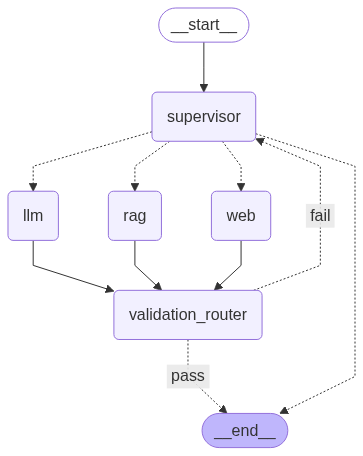

In [227]:
workflow = StateGraph(AgentState)

workflow.add_node('supervisor', supervisor)
workflow.add_node('rag', rag)
workflow.add_node('llm', llm)
workflow.add_node('web', web)
workflow.add_node('validation_router', validation_router)

workflow.add_conditional_edges('supervisor', router, {
    'rag': 'rag',
    'web': 'web',
    'llm': 'llm'
})

workflow.add_edge('rag', 'validation_router')
workflow.add_edge('llm', 'validation_router')
workflow.add_edge('web', 'validation_router')

workflow.add_conditional_edges('validation_router', validation_router, {
    'pass': '__end__',
    'fail': 'supervisor'
})

workflow.set_entry_point('supervisor')
workflow.add_edge("validation_router", END)  # NOT set_finish_point('__end__')

app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))


In [236]:
from langchain_core.messages import HumanMessage

app.invoke({
    "messages": [HumanMessage(content="Do you think India will be able to develop there own LLM?")],
    "validation_passed": False,
    "format_instructions": "Respond in 2 lines using clear, structured explanation."
})

[supervisor]: START: {'messages': [HumanMessage(content='Do you think India will be able to develop there own LLM?', additional_kwargs={}, response_metadata={})], 'validation_passed': False}
[supervisor]: END: {'messages': [HumanMessage(content='Do you think India will be able to develop there own LLM?', additional_kwargs={}, response_metadata={})], 'validation_passed': False}
messages: llm
EXIT from supervisor
inside llm node
[llm]: START: {'messages': [HumanMessage(content='Do you think India will be able to develop there own LLM?', additional_kwargs={}, response_metadata={}), 'llm'], 'validation_passed': False}
question: Do you think India will be able to develop there own LLM?
[llm]: END: {'messages': [HumanMessage(content='Do you think India will be able to develop there own LLM?', additional_kwargs={}, response_metadata={}), 'llm'], 'validation_passed': False}
messages: content="India has the potential to develop its own LLMs, but whether it will successfully create LLMs that are

TypeError: unhashable type: 'dict'